In [14]:
# Keep this cell while WIP
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import jax.random as jrd
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.math.psd_kernels as tfk
from liesel.goose.optim import Stopper, history_to_df

from batram.tmspat_jax.model import TransformationModel
from batram.tmspat_jax.node import (
    OnionCoefPredictivePointProcessGP,
    OnionKnots,
    ModelVar
)

key = jrd.PRNGKey(42)
k1, k2 = jrd.split(key)

In [16]:
loc_true = 2.0
scale_true = 1.5
concentration_true = 0.7
gev = tfd.GeneralizedExtremeValue(loc=loc_true, scale=scale_true, concentration=concentration_true)
y = gev.sample(sample_shape=(90, 100), seed=k1)

In [17]:
locs = jrd.uniform(key, shape=(y.shape[1], 2))
knots = OnionKnots(-3.0, 3.0, nparam=12)
locs_var = lsl.Var(locs, name="locs")

coef = OnionCoefPredictivePointProcessGP.new_from_locs(
    knots,
    inducing_locs=lsl.Var(locs[:-50, :], name="inducing_locs"),
    sample_locs=locs_var,
    kernel_cls=tfk.ExponentiatedQuadratic,
    amplitude=lsl.param(1.0, name="amplitude"),
    length_scale=lsl.param(1.0, name="length_scale"),
    name="coef",
)


loc = ModelVar(0.0, name="loc")
scale = ModelVar(1.0, bijector=tfb.Softplus(), name="scale")
concentration = ModelVar(0.3, name="concentration")

model = TransformationModel(
    y[:-50, :],
    knots=knots.knots,
    coef=coef,
    loc=loc,
    scale=scale,
    concentration=concentration,
    parametric_distribution=tfd.GeneralizedExtremeValue,
)

In [18]:
stopper = Stopper(max_iter=1000, patience=20)

result = model.fit_parametric_distributionloc_batched(
    train=y,
    validation=y,
    locs=locs_var,
    stopper=stopper
)

Training loss: 22186.279, Validation loss: 22186.279:  73%|███████▎  | 729/999 [00:06<00:01, 172.97it/s]

In [19]:
result.position

{'concentration_transformed': Array(0.7150099, dtype=float32),
 'loc_transformed': Array(1.9986597, dtype=float32),
 'scale_transformed': Array(1.2707864, dtype=float32)}

<Axes: xlabel='iteration'>

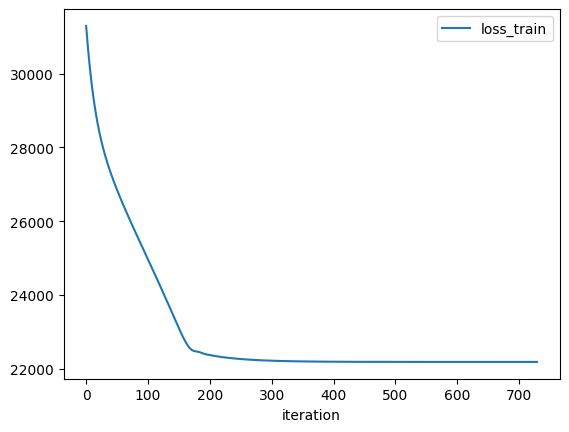

In [20]:
history_to_df(result.history)[["loss_train", "iteration"]].plot("iteration")

<Axes: xlabel='iteration'>

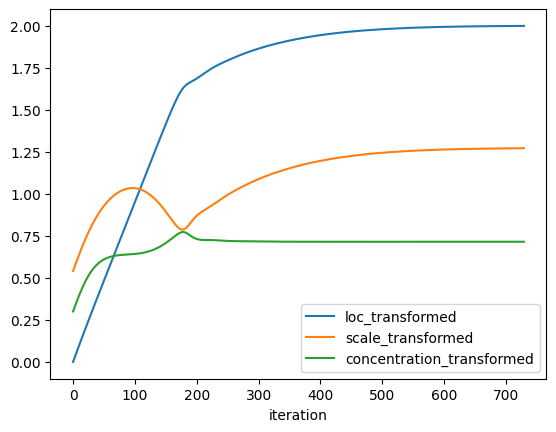

In [21]:
history_to_df(result.history)[["loc_transformed", "scale_transformed", "concentration_transformed", "iteration"]].plot("iteration")

In [22]:
result.model_state["scale_value"].value

Array(1.5181236, dtype=float32)

Training loss: 22186.279, Validation loss: 22186.279:  73%|███████▎  | 729/999 [00:22<00:01, 172.97it/s]